In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
def train_test_split_per_user(data, train_size=0.8, target_column='stress'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]

    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]

    x_train = train_data.drop(['id', target_column], axis=1)
    y_train = train_data[target_column]
    x_test = test_data.drop(['id', target_column], axis=1)
    y_test = test_data[target_column]

    return x_train, y_train, x_test, y_test

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
df = pd.read_pickle("../data/wesad/wesad_dataset.pkl")
df = df[df['stress'].notna()]
df

,id,EDA_0,EDA_1,EDA_2,EDA_3,TEMP_0,TEMP_1,TEMP_2,TEMP_3,ACC1_0,...,BVP_55,BVP_56,BVP_57,BVP_58,BVP_59,BVP_60,BVP_61,BVP_62,BVP_63,stress
0,2,5452.450365,5366.846848,5264.122627,5115.746165,10279.722091,10279.722091,10279.722091,10279.722091,126.326243,...,-104.371386,-124.493001,-136.216532,-137.408002,-128.387507,-111.782506,-91.536409,-71.450360,-54.013997,0.0
1,2,5264.122627,5115.746165,5127.156998,5013.021944,10279.722091,10279.722091,10279.722091,10279.722091,90.734562,...,40.556707,36.106477,30.326959,25.850055,23.818332,23.653838,23.849453,23.195923,21.515416,0.0
2,2,5127.156998,5013.021944,5372.556718,5235.591090,10279.722091,10279.722091,10279.722091,10279.722091,-27.904372,...,59.620226,48.839201,38.658357,31.562887,28.882079,28.415272,27.312718,22.711332,13.432982,0.0
3,2,5372.556718,5235.591090,5184.228979,5155.692989,10279.722091,10279.722091,10464.748540,10464.748540,-27.904372,...,-92.892373,-97.182554,-94.319469,-83.391734,-65.897576,-45.375840,-26.334550,-12.494826,-5.474934,0.0
4,2,5184.228979,5155.692989,5115.746165,5081.504758,10464.748540,10464.748540,10464.748540,10464.748540,-39.768266,...,-6.795332,-4.105633,-2.803019,-2.358440,-2.225067,-2.042790,-1.833838,-1.958320,-2.878597,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78761,17,-1141.515991,-1141.515991,-1146.439053,-1141.515991,-11412.917628,-11802.683112,-11802.683112,-11802.683112,57.652528,...,13.827887,13.207938,12.701858,12.233733,11.664393,10.917924,9.918415,8.640562,7.097016,0.0
78762,17,-1146.439053,-1141.515991,-1141.515991,-1141.515991,-11802.683112,-11802.683112,-11802.683112,-11802.683112,57.652528,...,-28.632268,-26.405514,-23.444943,-20.092160,-16.562248,-12.918468,-9.186125,-5.339913,-1.519005,0.0
78763,17,-1141.515991,-1141.515991,-1136.589079,-1151.365964,-11802.683112,-11802.683112,-11802.683112,-11802.683112,57.652528,...,12.448817,12.195777,11.816217,11.322788,10.753448,10.146151,9.526202,8.868298,8.045917,0.0
78764,17,-1136.589079,-1151.365964,-1141.515991,-1141.515991,-11802.683112,-11802.683112,-11802.683112,-11412.917628,57.652528,...,-9.110212,-7.427495,-5.491737,-3.189070,-0.544800,2.213339,4.908218,7.350056,9.450290,0.0


In [5]:
df['stress'].value_counts()

0.0    58834
1.0    19932
Name: stress, dtype: int64

# Generic model
each user belongs to either the train or the test set

In [6]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='stress')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(62784, 168) (62784,) (15982, 168) (15982,)


Dummy f1 score: 0.7410837191840821


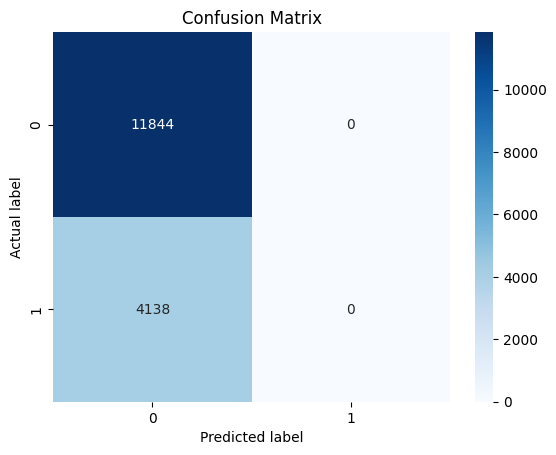

In [7]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_smote, y_train_smote)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [23]:
#clf = SVC(probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#clf = LogisticRegression(max_iter=200, random_state=42)
#clf = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
clf = LGBMClassifier(boosting_type='gbdt', n_estimators=100)

[LightGBM] [Info] Number of positive: 46990, number of negative: 46990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42840
[LightGBM] [Info] Number of data points in the train set: 93980, number of used features: 168
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
F1 Score: 0.886372168689776


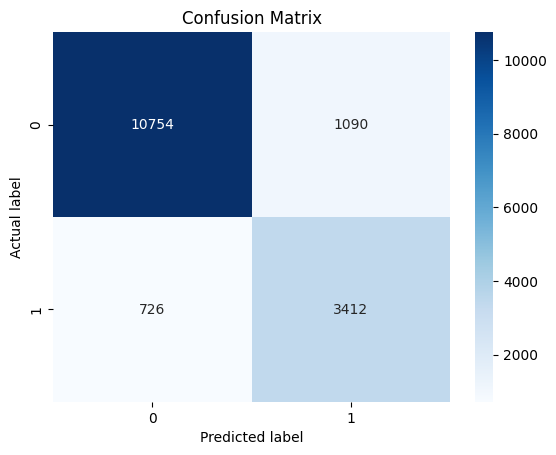

In [24]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
plot_confusion_matrix(y_test, y_pred)

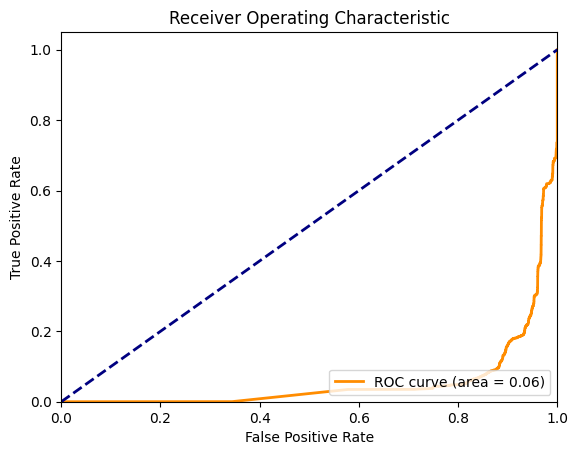

In [25]:
# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 0]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Leave one person out (LOPO) method

In [ ]:
X = df.drop(['stress', 'id'], axis=1)  # Features
y = df['stress']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

#model = DummyClassifier(strategy='most_frequent')
#model = SVC()
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100, random_state=42)
model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#model = LogisticRegression(random_state=42)
#model = LinearDiscriminantAnalysis(
#    covariance_estimator=None,
#    n_components=None,
#    priors=None,
#    shrinkage=None,
#    solver='svd',
#    store_covariance=False,
#    tol=0.0001
#)


cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1 score across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

In [ ]:
X = df.drop(['stress', 'id'], axis=1)  # Features
y = df['stress']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

#model = LogisticRegression(random_state=42)
model = LinearDiscriminantAnalysis(
    covariance_estimator=None,
    n_components=None,
    priors=None,
    shrinkage=None,
    solver='svd',
    store_covariance=False,
    tol=0.0001
)


cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []
all_y_pred = []
all_y_test = []
all_X_test = []

for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

    # Append the current iteration's data to the lists
    all_y_pred.extend(y_pred.tolist())
    all_y_test.extend(y_test.tolist())
    all_X_test.append(X_test)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

# Convert lists and DataFrame pieces to full DataFrames
all_y_pred_df = pd.DataFrame(all_y_pred, columns=['category_madrs'])
all_y_test_df = pd.DataFrame(all_y_test, columns=['category_madrs'])
all_X_test_df = pd.concat(all_X_test).reset_index(drop=True)

# Saving the DataFrames to CSV files
all_y_test_df.to_csv('../data/wesad/predictions/depresjon_y_test_LOPO.csv', index=False)
all_y_pred_df.to_csv('../data/wesad/predictions/depresjon_y_pred_LOPO.csv', index=False)
all_X_test_df.to_csv('../data/wesad/predictions/depresjon_X_test_LOPO.csv', index=False)